Libraries

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

Loading The Files

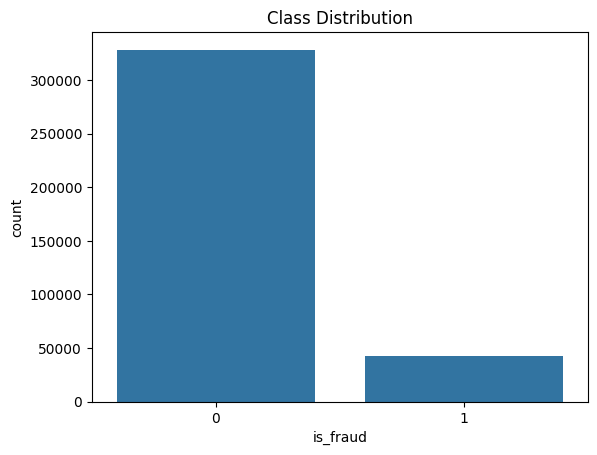

In [87]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

id_col = 'id'
target = 'is_fraud'

sns.countplot(x=train[target])
plt.title('Class Distribution')
plt.show()

Feature Engineering

In [88]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def extract_datetime_features(df):
    df['trans_datetime'] = pd.to_datetime(df['unix_time'], unit='s', errors='coerce')

    df['hour'] = df['trans_datetime'].dt.hour
    df['day'] = df['trans_datetime'].dt.day
    df['month'] = df['trans_datetime'].dt.month
    df['day_of_week'] = df['trans_datetime'].dt.dayofweek

    df['is_late_night'] = df['hour'].apply(lambda x: 1 if (x >= 22 or x <= 6) else 0)

    return df

def calculate_age(df):
    df['dob'] = pd.to_datetime(df['dob'], errors='coerce')

    df['age'] = df.apply(
        lambda row: row['trans_datetime'].year - row['dob'].year -
                    ((row['trans_datetime'].month, row['trans_datetime'].day) <
                     (row['dob'].month, row['dob'].day))
        if pd.notnull(row['dob']) and pd.notnull(row['trans_datetime']) else np.nan,
        axis=1
    )

    df['age'] = df['age'].clip(lower=0, upper=100)

    df = df.drop(['dob', 'trans_datetime'], axis=1)

    return df

def calculate_distance(df):
    df['distance_km'] = haversine_distance(df['lat'], df['long'], df['merch_lat'], df['merch_long'])
    return df

def encode_and_scale_features(df, label_encoders=None, scaler=None, fit=True):
    categorical_columns = ['category', 'gender', 'state', 'job']
    numerical_columns = ['amt', 'distance_km', 'city_pop', 'age']

    if fit:
        label_encoders = {}
        for col in categorical_columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].fillna('Unknown'))
            label_encoders[col] = le
    else:
        for col in categorical_columns:
            df[col] = df[col].fillna('Unknown')
            df[col] = df[col].apply(lambda x: x if x in label_encoders[col].classes_ else 'Unknown')
            df[col] = label_encoders[col].transform(df[col])

    if fit:
        scaler = StandardScaler()
        df[numerical_columns] = scaler.fit_transform(df[numerical_columns].fillna(0))
    else:
        df[numerical_columns] = scaler.transform(df[numerical_columns].fillna(0))

    return df, label_encoders, scaler

def preprocess_data(df, label_encoders=None, scaler=None, fit=True):
    df = extract_datetime_features(df)

    df = calculate_age(df)

    df = calculate_distance(df)

    drop_cols = [
        'trans_num', 'trans_date', 'trans_time', 'unix_time',
        'first', 'last', 'street', 'city', 'zip', 'lat', 'long',
        'merch_lat', 'merch_long', 'dob'
    ]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    df, label_encoders, scaler = encode_and_scale_features(df, label_encoders, scaler, fit)

    feature_columns = [
        'amt', 'distance_km', 'city_pop',
        'hour', 'day', 'month', 'day_of_week', 'is_late_night', 'age',
        'category', 'gender', 'state', 'job'
    ]
    X = df[feature_columns]

    y = df[target] if target in df.columns else None

    return X, y, label_encoders, scaler

X, y, label_encoders, scaler = preprocess_data(train, fit=True)

X_test, _, _, _ = preprocess_data(test, label_encoders=label_encoders, scaler=scaler, fit=False)

X = X.fillna(0)
X_test = X_test.fillna(0)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Model Training and Evaluation

In [89]:
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred_val = rf_model.predict(X_val)
val_f1 = f1_score(y_val, y_pred_val)
print("Validation F1-score:", val_f1)

Validation F1-score: 0.9607218683651805


Create Submission File

In [90]:
y_test_pred = rf_model.predict(X_test)

submission = pd.DataFrame({
    'id': test[id_col],
    'is_fraud': y_test_pred
})

submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv
